# Project 3: Subreddit Classification
---
Project notebook organisation:<br>
[1 - Webscraping and Data Acquisition](./1_webscraping_and_data_acquisition)<br>
**2 - Exploratory Data Analysis and Preprocessing** (current notebook)<br>
[3 - Model Tuning and Insights](./3_model_tuning_and_insights.ipynb)<br>
<br>
<br>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import scipy.stats as stats
import warnings
from wordcloud import WordCloud, ImageColorGenerator
import regex as re

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

warnings.filterwarnings('ignore')
sns.set_style('ticks')
pd.set_option('display.max_columns', None)

%matplotlib inline

## Introduction
---

In this notebook I will examine data obtained from webscraping both subreddits (from the previous notebook), looking specifically at common words and distributions of various features such as title lengths. I will also be carrying out data cleaning and feature engineering to create features that will help to better build the classification model (in the next notebook).

### Contents
1. [First impressions](#First-impressions)
2. [Most common words before preprocessing](#Most-common-words-before-preprocessing)
3. [Data cleaning and feature engineering](#Data-cleaning-and-feature-engineering)
4. [Lengths of contents](#Lengths-of-contents)
5. [Most common words after preprocessing](#Most-common-words-after-preprocessing)
6. [EDA conclusion](#EDA-conclusion)

## First impressions
---

A total of 980 posts from r/Singapore and 1000 posts from r/Malaysia were scraped, containing 13878 and 8239 comments respectively. These were from a time span of about 2 weeks, from 26 Sep to 17 October 2019 for r/Singapore and from 23 Sep to 17 Oct 2019 for r/Malaysia.

It is interesting to note that very few posts have texts in their body, as indicted by the non-null values in the `text` columns - only 354 out of 980 in r/Singapore and a mere 206 out of 1000 in r/Malaysia (as shown in the [plot below](#Percentage-of-text-posts), indicating that majority of the posts are links, images, or consists purely of e.g. a question in the title.

There are relatively few content from moderators (20 from r/Singapore and 24 from r/Malaysia for posts, and 1 from r/Singapore and 38 from r/Malaysia).

### Import data

In [38]:
sg_posts = pd.read_csv('../data/train/sg_posts.csv', index_col = 0)
sg_comments = pd.read_csv('../data/train/sg_comments.csv', index_col = 0)
ms_posts = pd.read_csv('../data/train/ms_posts.csv', index_col = 0)
ms_comments = pd.read_csv('../data/train/ms_comments.csv', index_col = 0)

### r/Singapore

In [39]:
sg_posts.head()

,title,id,date_created,text,distinguished,score,upvote_ratio
0,What does r/Singapore think of this Quora post...,dj55oo,2019-10-17 11:40:14,What do you think of this [post](https://www.q...,NaN,1,1.0
1,Looking for 2nd hand Wangan Midnight Manga in ...,dj537j,2019-10-17 11:33:51,"Hello, r/singapore ! I'm French, and I'm searc...",NaN,1,1.0
2,SPH to lay off 5 per cent of staff in media gr...,dj51xz,2019-10-17 11:30:10,NaN,NaN,2,1.0
3,S’poreans Caught At Manila Airport For Bringin...,dj514i,2019-10-17 11:28:08,NaN,NaN,2,1.0
4,YouTrip vs TranferWise?,dj4sog,2019-10-17 11:04:21,"Hi all,\n\n\nTransferWise just rolled out its ...",NaN,5,1.0


In [40]:
sg_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980 entries, 0 to 979
Data columns (total 7 columns):
title            980 non-null object
id               980 non-null object
date_created     980 non-null object
text             345 non-null object
distinguished    20 non-null object
score            980 non-null int64
upvote_ratio     980 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 61.2+ KB


In [41]:
print(sg_posts.date_created.max())
print(sg_posts.date_created.min())

2019-10-17 11:40:14
2019-09-26 23:51:55


In [42]:
sg_comments.head()

,post_id,comment_text,comment_distinguished,comment_score
0,dj51xz,> # SPH to lay off 5 per cent of staff in medi...,NaN,1
1,dj51xz,snakes head right on the top is still there th...,NaN,1
2,dj514i,Dim Sum night for the staff.\n\nBut seriously....,NaN,1
3,dj4sog,Transferwise charges conversion fees for every...,NaN,1
4,dj4sog,I’ve had the TransferWise MasterCard debit car...,NaN,1


In [43]:
sg_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46264 entries, 0 to 46263
Data columns (total 4 columns):
post_id                  46264 non-null object
comment_text             46264 non-null object
comment_distinguished    30 non-null object
comment_score            46264 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


In [44]:
print(sg_posts.shape)
print(sg_comments.shape)

(980, 7)
(46264, 4)


### r/Malaysia

In [45]:
ms_posts.head()

,title,id,date_created,text,distinguished,score,upvote_ratio
0,Cambridge-based Malaysian wins 'Nobel Prize fo...,dj58at,2019-10-17 11:47:12,NaN,NaN,9,1.00
1,Expired Passport and no MyKad,dj4rbb,2019-10-17 11:00:29,"Hi everyone,\n\nI was born in Malaysia to a Ma...",NaN,3,1.00
2,Fisherman gets 202 years for raping stepdaught...,dj4k9c,2019-10-17 10:40:25,NaN,NaN,3,1.00
3,9 syarikat disenarai hitam terlibat penyelewen...,dj4dec,2019-10-17 10:20:00,NaN,NaN,3,1.00
4,Any proud Hindi speakers in Malaysia? Malaysia...,dj2ozw,2019-10-17 07:03:15,With a large Indian diaspora (of mostly Tamil ...,NaN,3,0.72


In [46]:
ms_posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 7 columns):
title            999 non-null object
id               999 non-null object
date_created     999 non-null object
text             199 non-null object
distinguished    24 non-null object
score            999 non-null int64
upvote_ratio     999 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 62.4+ KB


In [47]:
print(ms_posts.date_created.max())
print(ms_posts.date_created.min())

2019-10-17 11:47:12
2019-09-23 03:29:32


In [48]:
ms_comments.head()

,post_id,comment_text,comment_distinguished,comment_score
0,dj58at,There is still a Nobel Prize for medicine and ...,NaN,1
1,dj4rbb,Which country are you currently in? Have you c...,NaN,2
2,dj4rbb,Is there a Malaysian embassy at the country yo...,NaN,2
3,dj4k9c,Monster bastard.,NaN,1
4,dj4k9c,Fucking cunt. Should cut his dick off.,NaN,1


In [49]:
ms_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24875 entries, 0 to 24874
Data columns (total 4 columns):
post_id                  24875 non-null object
comment_text             24875 non-null object
comment_distinguished    92 non-null object
comment_score            24875 non-null int64
dtypes: int64(1), object(3)
memory usage: 971.7+ KB


In [50]:
print(ms_posts.shape)
print(ms_comments.shape)

(999, 7)
(24875, 4)


### Percentage of text posts

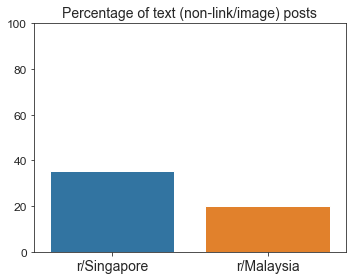

In [51]:
sg_posts_notnull = sg_posts.notnull().sum()['text']/sg_posts.shape[0] * 100
ms_posts_notnull = ms_posts.notnull().sum()['text']/ms_posts.shape[0] * 100

plt.figure(figsize = (5,4))
sns.barplot(y = [sg_posts_notnull, ms_posts_notnull], x = ['r/Singapore','r/Malaysia'])
plt.title('Percentage of text (non-link/image) posts', fontsize=14)
plt.ylim(0,100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()

## Most common words before preprocessing
---

A simple count vectoriser (using the default `sklearn`'s english stop words and without any customised parameters) was used to transform the text data and to extract n-grams for preliminary visualisations. Bi-grams and tri-grams were used to extract some context.

From the graphs below, it is evident that the two corpora contain a large amount of noise, which can be attributed to:
- daily discussion posts made by moderators (evident from the "questions thread", "singapore random discussion", "malaysia daily random" etc)
- posts containing large amounts of html links (evident from the "https www", "google maps", "reddit com" and the large number of random strings)

It is also apparent that additional stopwords need to be added to the default `sklearn` stopwords, such as 'Singapore', 'Malaysia', 'Singaporean', 'Malaysian', etc.

Despite the noisy data, some differences between the two subreddits are already apparent from the graphs below. Some topics specific to r/Singapore (as seen in the post titles) include 'pm lee', 'toa payoh', 'yale nus', while those unique to r/Malaysia include 'dr mahathir', 'budget 2020', and 'malay dignity congress'. The post bodies are less informative in their content at the moment, due to the amount of noise they currently contain (and also likely due to the relatively few posts that contain actual text). 

Word frequencies will be examined again after preprocessing and engineering, where their signals will become more apparent.

(An attempt was made to vectorise and visualise the comments corpus, however it kept crashing the kernel in Jupyter, likely due to its large size and limited computing power on the local machine. Therefore I decided to not use the text data at the moment, but will instead use it to obtain the total comment count for each post and append that to the dataframe containing the main posts.)

In [52]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(2,3))

### Title content

The most common words by count is simply the sum of all the occurrences of a word in a corpus - in this case, in r/Singapore and r/Malaysia.

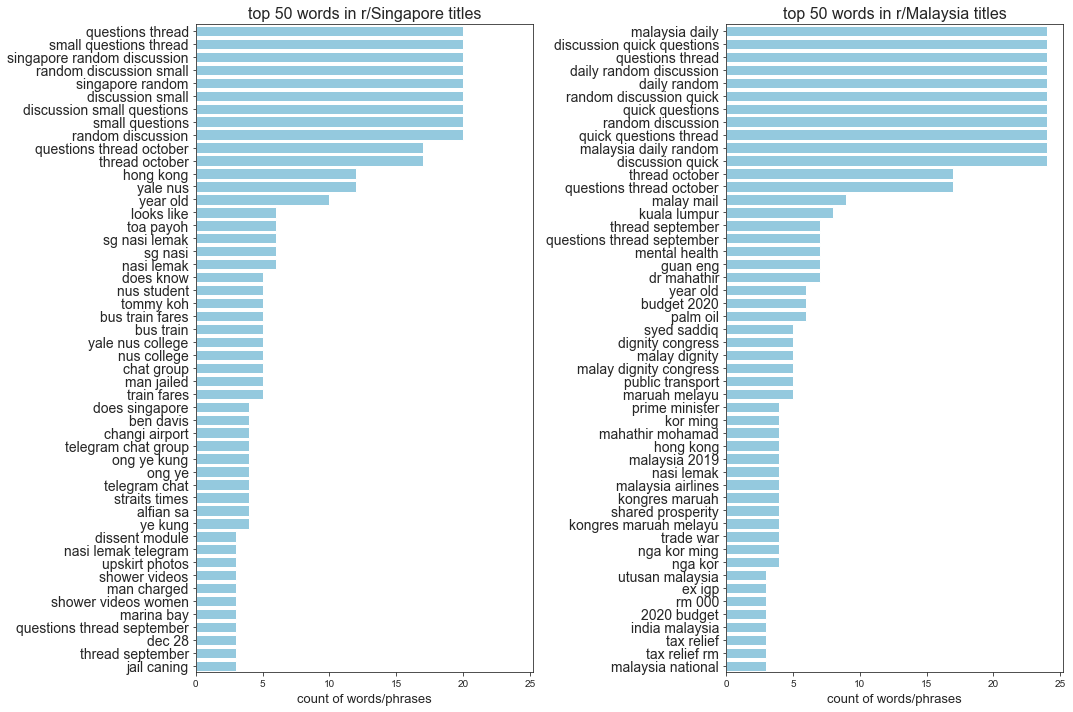

In [53]:
# r/Singapore - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_sg = cvec.fit_transform(sg_posts['title'])
vec_sg = pd.DataFrame(vec_sg.toarray(), columns = cvec.get_feature_names())
sg_title_50 = vec_sg.sum().sort_values(ascending=False).head(50)

# r/Malaysia - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_ms = cvec.fit_transform(ms_posts['title'])
vec_ms = pd.DataFrame(vec_ms.toarray(), columns = cvec.get_feature_names())
ms_title_50 = vec_ms.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=sg_title_50.index.values, x = sg_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/Singapore titles',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=ms_title_50.index.values, x = ms_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/Malaysia titles',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

### Post content

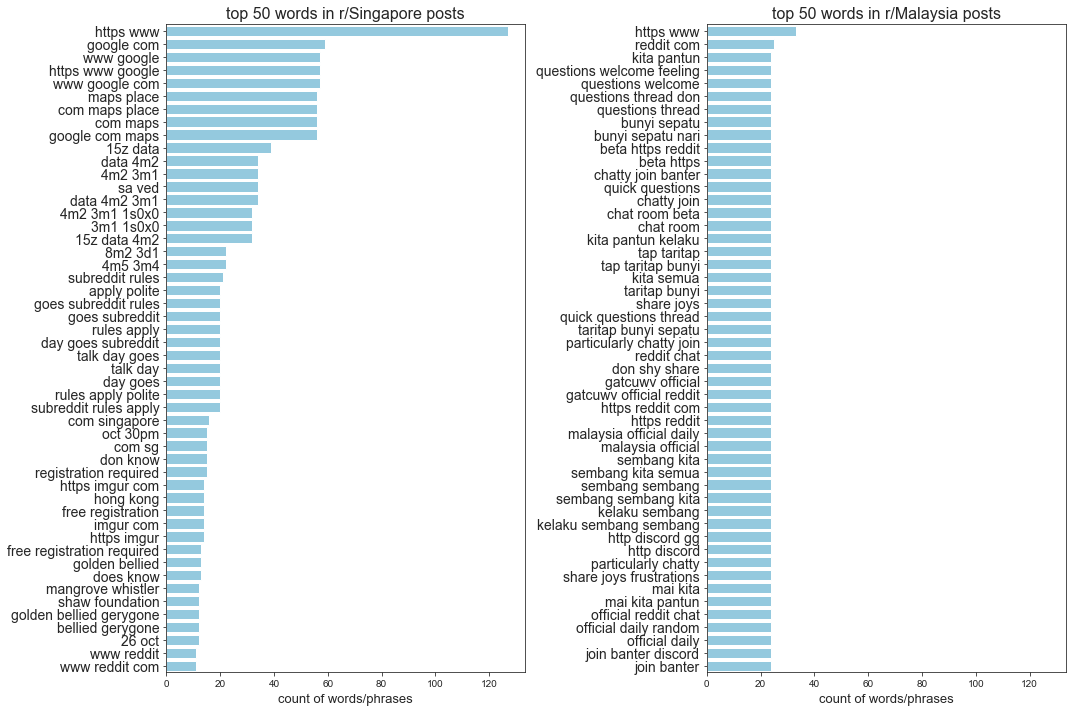

In [54]:
# preliminary filling of nan values for vectorising/plotting
sg_posts['text'].fillna(value = 'notexthere', inplace=True)
ms_posts['text'].fillna(value = 'notexthere', inplace=True)

# r/Singapore - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_sg = cvec.fit_transform(sg_posts['text'])
vec_sg = pd.DataFrame(vec_sg.toarray(), columns = cvec.get_feature_names())
sg_post_50 = vec_sg.sum().sort_values(ascending=False).head(50)

# r/Malaysia - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_ms = cvec.fit_transform(ms_posts['text'])
vec_ms = pd.DataFrame(vec_ms.toarray(), columns = cvec.get_feature_names())
ms_post_50 = vec_ms.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=sg_post_50.index.values, x = sg_post_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/Singapore posts',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=ms_post_50.index.values, x = ms_post_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/Malaysia posts',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

### Closer examinations of noisy phrases

Some examples of stickied moderator posts from r/Singapore and r/Malaysia are shown below, which are posted daily and are intended for "random discussions and small questions" that do not warrant an entire post to themselves. They largely contain the same title and text, which highly skews the word frequency distributions. As these moderator posts are relatively few in the two corpora (as shown in the summary counts below), they will be removed. 

In [55]:
sg_posts[sg_posts['title'].str.contains('questions thread')].head()

,title,id,date_created,text,distinguished,score,upvote_ratio
29,/r/singapore random discussion and small quest...,diwndd,2019-10-16 22:04:58,"Talk about your day. Anything goes, but subred...",moderator,19,0.92
71,/r/singapore random discussion and small quest...,difb6g,2019-10-15 22:04:42,"Talk about your day. Anything goes, but subred...",moderator,8,0.81
118,/r/singapore random discussion and small quest...,dhxxqo,2019-10-14 22:04:42,"Talk about your day. Anything goes, but subred...",moderator,14,0.89
166,/r/singapore random discussion and small quest...,dhhbg8,2019-10-13 22:04:52,"Talk about your day. Anything goes, but subred...",moderator,14,0.80
201,/r/singapore random discussion and small quest...,dh1nhm,2019-10-12 22:04:49,"Talk about your day. Anything goes, but subred...",moderator,9,0.79


In [56]:
ms_posts[ms_posts['title'].str.contains('questions thread')].head()

,title,id,date_created,text,distinguished,score,upvote_ratio
25,/r/malaysia daily random discussion and quick ...,diuwvo,2019-10-16 20:05:31,This is /r/malaysia's official daily random di...,moderator,4,0.86
57,/r/malaysia daily random discussion and quick ...,didjv8,2019-10-15 20:05:34,This is /r/malaysia's official daily random di...,moderator,4,0.83
91,/r/malaysia daily random discussion and quick ...,dhw7ie,2019-10-14 20:06:00,This is /r/malaysia's official daily random di...,moderator,6,0.82
145,/r/malaysia daily random discussion and quick ...,dhfqsd,2019-10-13 20:05:55,This is /r/malaysia's official daily random di...,moderator,5,0.83
176,/r/malaysia daily random discussion and quick ...,dh05cq,2019-10-12 20:05:28,This is /r/malaysia's official daily random di...,moderator,10,0.78


In [57]:
# number of moderator posts
print(sg_posts.distinguished.value_counts())
print(ms_posts.distinguished.value_counts())

moderator    20
Name: distinguished, dtype: int64
moderator    24
Name: distinguished, dtype: int64


Shown below is a post titled "What's Happening in October 2019?", a post that contains in its body text a detailed list of events and links to their locations and event websites, etc. This is a monthly post in r/Singapore and is likely the source for most of the html-related noise in the corpus of this subreddit.

In [58]:
sg_posts.iloc[764,:]['text']

'Credit to [u/eilletane](https://www.reddit.com/u/eilletane/) for the format. \u200b\n\n**Ongoing Events**\n\n|**DATE**|TIME|CATEGORY|EVENT|VENUE|PRICE|\n|:-|:-|:-|:-|:-|:-|\n|17 Oct|9:30am - 5pm|Conference|[SG:D Industry Day 2019](https://www.sgdigitalindustryday.com/)|[Suntec City Convention Centre](https://goo.gl/maps/s7YzLPPDy4pkEmtN8)|Free|\n|17 Oct|7:30pm & 9pm|Arts|[ArtScience Late: iNCH](https://www.marinabaysands.com/museum/exhibitions-and-events/artscience-late.html)|[ArtScience Museum](https://www.google.com/maps/place/ArtScience+Museum/@1.2862738,103.8592663,15z/data=!4m2!3m1!1s0x0:0x81c847e129eec549?sa=X&ved=2ahUKEwjBpJjO2v_kAhV6H7cAHVyODZMQ_BIwFnoECAoQCA), Level 4, Expression Gallery|Free on a first-come-first-served basis, limited capacity.|\n|3-20 Oct|10am - 9.30pm|Food|[Japan Food Matsuri](https://www.takashimaya.com.sg/post_events/japan-food-matsuri/)|[Takashimaya Square](https://www.google.com/maps/place/Takashimaya+Square/@1.3027123,103.8324345,17z/data=!3m2!4b1!5s0

## Data cleaning and feature engineering
---

In this section, I addressed the problems identified during the preliminary EDA, engineered a few new columns, and merged all posts and comments dataframes.

### Check and remove cross-posts

Given the similarities between r/Singapore and r/Malaysia, there may be crossposts between the two subreddits. Unfortunately, the only way to check for them is by post title (which may not always be the same).

In [59]:
common_posts = pd.merge(sg_posts, ms_posts, 
                        left_on = 'title',
                        right_on = 'title', 
                        how = 'outer')
common_posts[~common_posts.isnull().any(axis=1)]

# no common posts between the two, i.e. no crossposts

,title,id_x,date_created_x,text_x,distinguished_x,score_x,upvote_ratio_x,id_y,date_created_y,text_y,distinguished_y,score_y,upvote_ratio_y


### Define preprocessing function

As seen from the previous section, the raw corpus contains several issues which will be addressed in the preprocessing function below:
- remove moderator posts and moderator comments (as indicated in the `distinguished` column)
- fill in null values that represent no post texts/no comments with a unique string that will later be included as a stopword
- engineer new columns for comment count and number of words in the comments for each post
- join comment count and comment length to each post
- engineer new columns for title lengths and post lengths
- remove html links in title, post, and comment texts

In [60]:
def preprocess(df_posts, df_comments):
    
    # ----------------------------- REMOVE MODERATOR POSTS -----------------------------
    
    df_posts = df_posts[df_posts.distinguished != 'moderator']
    df_posts.drop(columns = 'distinguished', inplace = True)

    # ------------------------------- FILL IN NULL VALUES ------------------------------
    
    df_posts.fillna(value = 'notexthere', inplace=True)

#     # ------------------------------- REMOVE NEWEST POSTS ------------------------------
    
#     latest_date = pd.to_datetime(df_posts['date_created'].max()) - pd.Timedelta(days=1)
#     df_posts['date_created'] = pd.to_datetime(df_posts['date_created'])
#     df_posts = df_posts[df_posts['date_created'] < latest_date]
    
    # ---------------------------- REMOVE MODERATOR COMMENTS ---------------------------

    df_comments = df_comments[df_comments.comment_distinguished != 'moderator']
    df_comments.drop(columns = 'comment_distinguished', inplace = True)
    
# #    ------------------------------- REMOVE BOT COMMENTS ------------------------------
    
#     # in r/Singapore, there is a retriever got that posts the full article in a comment
#     # if the main post is a news link, e.g. to the Straits Times website
#     df_comments.drop(df_comments[df_comments['comment_text'].str.contains('github')].index,
#                     axis = 0, inplace = True)
    
    # -------------------------------- GET COMMENTS INFO -------------------------------
    
    # calculate comment counts and lengths for each post
    df_comments = df_comments.groupby('post_id')['comment_text'].\
                                    agg(['count', lambda text: '. '.join(text)])
    df_comments = pd.DataFrame(df_comments)
    df_comments['comment_len'] = [len(x) for x in df_comments['<lambda_0>'].str.split(' ')]
    df_comments.rename(columns={'<lambda_0>': 'comment_all',
                                'count':'comment_count'}, inplace = True)

    # join comments to posts on post_id
    df_merged = df_posts.merge(df_comments, how = 'left', left_on = 'id', right_on = 'post_id')
    
    # fill in null values for posts with no comments
    df_merged['comment_count'].fillna(0, inplace = True)
    df_merged['comment_len'].fillna(0, inplace = True)
    df_merged['comment_all'].fillna('notexthere', inplace = True)
    
    # -------------------------------- GET TEXT LENGTHS ----------------------------------
    
    df_merged['title_len'] = [len(x) for x in df_merged['title'].str.split(' ')]
    df_merged['text_len'] = [len(x) for x in df_merged['text'].str.split(' ')]

    # ---------------------------------- REMOVE LINKS -----------------------------------
    
    regex_html = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
    df_merged['title'].replace(regex=True,inplace=True, to_replace=regex_html,value=r'')
    df_merged['text'].replace(regex=True,inplace=True, to_replace=regex_html,value=r'')
    df_merged['comment_all'].replace(regex=True,inplace=True, to_replace=regex_html,value=r'')
    
    return df_merged

### Run preprocessing function

Everything looks good and there're no null values.

In [61]:
# remove post in r/singapore with lots of links
sg_posts.drop(index = 764, inplace = True)

sg_merged = preprocess(sg_posts, sg_comments)
print(sg_merged.info())
sg_merged.head() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 0 to 958
Data columns (total 11 columns):
title            959 non-null object
id               959 non-null object
date_created     959 non-null object
text             959 non-null object
score            959 non-null int64
upvote_ratio     959 non-null float64
comment_count    959 non-null float64
comment_all      959 non-null object
comment_len      959 non-null float64
title_len        959 non-null int64
text_len         959 non-null int64
dtypes: float64(3), int64(3), object(5)
memory usage: 89.9+ KB
None


,title,id,date_created,text,score,upvote_ratio,comment_count,comment_all,comment_len,title_len,text_len
0,What does r/Singapore think of this Quora post...,dj55oo,2019-10-17 11:40:14,What do you think of this [post]( from Quora t...,1,1.0,0.0,notexthere,0.0,23,22
1,Looking for 2nd hand Wangan Midnight Manga in ...,dj537j,2019-10-17 11:33:51,"Hello, r/singapore ! I'm French, and I'm searc...",1,1.0,0.0,notexthere,0.0,9,49
2,SPH to lay off 5 per cent of staff in media gr...,dj51xz,2019-10-17 11:30:10,notexthere,2,1.0,2.0,> # SPH to lay off 5 per cent of staff in medi...,499.0,17,1
3,S’poreans Caught At Manila Airport For Bringin...,dj514i,2019-10-17 11:28:08,notexthere,2,1.0,1.0,Dim Sum night for the staff.\n\nBut seriously....,22.0,17,1
4,YouTrip vs TranferWise?,dj4sog,2019-10-17 11:04:21,"Hi all,\n\n\nTransferWise just rolled out its ...",5,1.0,2.0,Transferwise charges conversion fees for every...,162.0,3,85


In [62]:
ms_merged = preprocess(ms_posts, ms_comments)
print(ms_merged.info())
ms_merged.head() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 975 entries, 0 to 974
Data columns (total 11 columns):
title            975 non-null object
id               975 non-null object
date_created     975 non-null object
text             975 non-null object
score            975 non-null int64
upvote_ratio     975 non-null float64
comment_count    975 non-null float64
comment_all      975 non-null object
comment_len      975 non-null float64
title_len        975 non-null int64
text_len         975 non-null int64
dtypes: float64(3), int64(3), object(5)
memory usage: 91.4+ KB
None


,title,id,date_created,text,score,upvote_ratio,comment_count,comment_all,comment_len,title_len,text_len
0,Cambridge-based Malaysian wins 'Nobel Prize fo...,dj58at,2019-10-17 11:47:12,notexthere,9,1.00,1.0,There is still a Nobel Prize for medicine and ...,18.0,10,1
1,Expired Passport and no MyKad,dj4rbb,2019-10-17 11:00:29,"Hi everyone,\n\nI was born in Malaysia to a Ma...",3,1.00,2.0,Which country are you currently in? Have you c...,33.0,5,83
2,Fisherman gets 202 years for raping stepdaught...,dj4k9c,2019-10-17 10:40:25,notexthere,3,1.00,3.0,Monster bastard.. Fucking cunt. Should cut his...,22.0,16,1
3,9 syarikat disenarai hitam terlibat penyelewen...,dj4dec,2019-10-17 10:20:00,notexthere,3,1.00,0.0,notexthere,0.0,8,1
4,Any proud Hindi speakers in Malaysia? Malaysia...,dj2ozw,2019-10-17 07:03:15,With a large Indian diaspora (of mostly Tamil ...,3,0.72,2.0,Head over to laxmi Narayan temple. Plenty of H...,51.0,10,60


### Merge dataframes

In [63]:
# create dummy column for subreddits - 1 for r/singapore and 0 for r/malaysia
sg_merged['subreddit'] = 1
ms_merged['subreddit'] = 0

# combine dataframes
combined = sg_merged.append(ms_merged)
combined.sample(5)

,title,id,date_created,text,score,upvote_ratio,comment_count,comment_all,comment_len,title_len,text_len,subreddit
353,MRT/BUS Peak hours vs Taxi Peak hours,df9fg6,2019-10-09 00:49:55,I realised that the so called peak hour for ...,1,0.50,7.0,"Peak hour is a function of user behavior, and ...",480.0,7,32,1
329,Found a rare gem.,dey5g4,2019-10-08 10:35:46,notexthere,23,0.79,16.0,Pffftr please i have that alot in my money box...,138.0,4,1,0
266,JustGrab passenger calls taxi driver ‘absolute...,dg905v,2019-10-11 02:57:53,notexthere,96,0.96,208.0,"when you pay a metered fee, you have interest ...",10259.0,12,1,1
534,Penang Hills Watch calls for probe on source o...,dcmmvr,2019-10-03 05:41:43,notexthere,13,0.85,1.0,>They said the hills and seas are Penang’s nat...,56.0,18,1,0
140,anyone know where that black and orange buildi...,dhni1r,2019-10-14 08:05:44,notexthere,7,0.76,5.0,Safra toa payoh ?. Looks like that bin center ...,26.0,9,1,1


In [64]:
# check presence of both subreddits
combined.subreddit.value_counts()

0    975
1    959
Name: subreddit, dtype: int64

## Lengths of contents
---

The title lengths and title length distributions are fairly similar between the two subreddits, as shown in the graphs below. r/Singapore had a mean title length of 10.47 words (SD = 5.91), while r/Malaysia had a mean title length of 10.63 words (SD = 7.27). 

However, r/Singapore had much longer posts. Post lengths in r/Singapore averaged at 42.31 words (with a high standard deviation of 127.28 words), while the mean post length in r/Malaysia was about half as long, at 22.37 words (SD = 76.78). The shortest posts had no content (the length of 1 represent the filler word imputed when filling in empty posts), and represent either links or image posts. While posts in r/Singapore had 31.50 words at the 75% percentile, 75% of posts in r/Malaysia had no words. As also shown in [section 1](#Percentage-of-text-posts), majority of the posts from both subreddits had no words. 

r/Malaysia had shorter comments on average as well, with a mean total comment length of 509.67 words on each post (SD = 1012.54). Each post in r/Singapore had an average of 1209.98 words in its comments (SD = 2691.92).

The distributions of title lengths, post lengths, and comment lengths are all right skewed with lots of outliers at the upper bound (see boxplots below). The outliers will not be removed at this point, as the text they contain would be important for model training. 

In [65]:
sg_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
score,959.0,108.946820,307.210573,0.00,6.00,24.00,70.50,4204.0
upvote_ratio,959.0,0.779645,0.181782,0.13,0.69,0.83,0.92,1.0
comment_count,959.0,28.894682,47.090465,0.00,6.00,15.00,34.00,580.0
comment_len,959.0,1210.713243,2693.230562,0.00,166.50,524.00,1280.00,45517.0
title_len,959.0,10.475495,5.908238,1.00,6.00,10.00,14.00,47.0
text_len,959.0,42.306569,127.283460,1.00,1.00,1.00,31.50,1447.0
subreddit,959.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.0


In [66]:
ms_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
score,975.0,66.486154,149.941466,0.00,8.0,17.00,44.00,1096.0
upvote_ratio,975.0,0.857590,0.127165,0.27,0.8,0.88,0.95,1.0
comment_count,975.0,18.411282,26.905800,0.00,4.0,10.00,22.00,362.0
comment_len,975.0,509.670769,1012.543972,0.00,60.0,207.00,562.50,18315.0
title_len,975.0,10.631795,7.266334,1.00,6.0,9.00,13.00,55.0
text_len,975.0,22.376410,78.782202,1.00,1.0,1.00,1.00,1139.0
subreddit,975.0,0.000000,0.000000,0.00,0.0,0.00,0.00,0.0


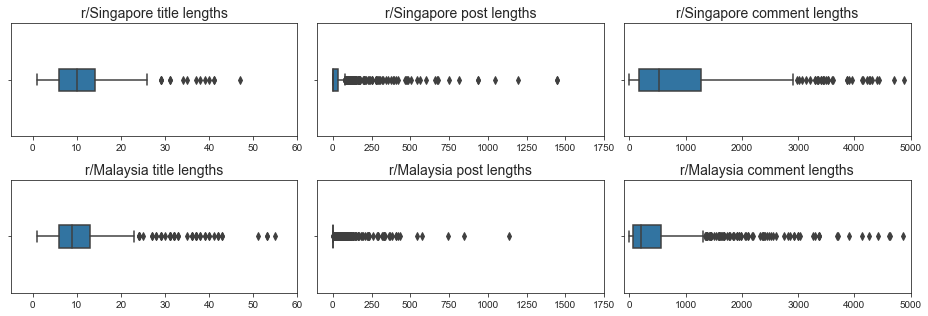

In [67]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (13, 4.5))

sns.boxplot(sg_merged['title_len'], ax = ax[0][0], width = 0.2)
ax[0][0].set_xlabel('')
ax[0][0].set_xlim(-5,60)
ax[0][0].set_title('r/Singapore title lengths', fontsize=14)
sns.boxplot(sg_merged['text_len'], ax = ax[0][1], width = 0.2)
ax[0][1].set_xlabel('')
ax[0][1].set_xlim(-100,1750)
ax[0][1].set_title('r/Singapore post lengths', fontsize=14)
sns.boxplot(sg_merged['comment_len'], ax = ax[0][2], width = 0.2)
ax[0][2].set_xlabel('')
ax[0][2].set_xlim(-100,5000)
ax[0][2].set_title('r/Singapore comment lengths', fontsize=14)

sns.boxplot(ms_merged['title_len'], ax = ax[1][0], width = 0.2)
ax[1][0].set_xlabel('')
ax[1][0].set_xlim(-5,60)
ax[1][0].set_title('r/Malaysia title lengths', fontsize=14)
sns.boxplot(ms_merged['text_len'], ax = ax[1][1], width = 0.2)
ax[1][1].set_xlabel('')
ax[1][1].set_xlim(-100,1750)
ax[1][1].set_title('r/Malaysia post lengths', fontsize=14)
sns.boxplot(ms_merged['comment_len'], ax = ax[1][2], width = 0.2)
ax[1][2].set_xlabel('')
ax[1][2].set_xlim(-100,5000)
ax[1][2].set_title('r/Malaysia comment lengths', fontsize=14)

plt.tight_layout()

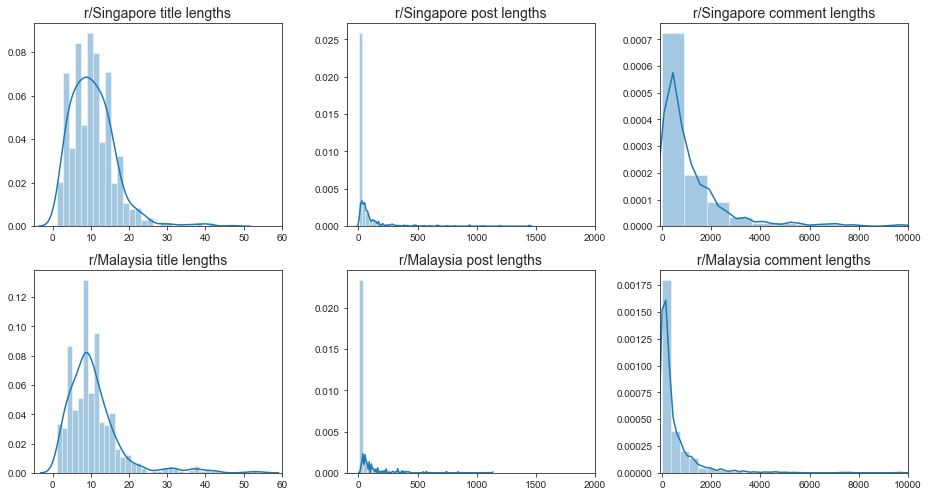

In [68]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (13, 7))

sns.distplot(sg_merged['title_len'], ax = ax[0][0])
ax[0][0].set_xlabel('')
ax[0][0].set_xlim(-5,60)
ax[0][0].set_title('r/Singapore title lengths', fontsize=14)
sns.distplot(sg_merged['text_len'], ax = ax[0][1])
ax[0][1].set_xlabel('')
ax[0][1].set_xlim(-100,2000)
ax[0][1].set_title('r/Singapore post lengths', fontsize=14)
sns.distplot(sg_merged['comment_len'], ax = ax[0][2])
ax[0][2].set_xlabel('')
ax[0][2].set_xlim(-100,10000)
ax[0][2].set_title('r/Singapore comment lengths', fontsize=14)

sns.distplot(ms_merged['title_len'], ax = ax[1][0])
ax[1][0].set_xlabel('')
ax[1][0].set_xlim(-5,60)
ax[1][0].set_title('r/Malaysia title lengths', fontsize=14)
sns.distplot(ms_merged['text_len'], ax = ax[1][1])
ax[1][1].set_xlabel('')
ax[1][1].set_xlim(-100,2000)
ax[1][1].set_title('r/Malaysia post lengths', fontsize=14)
sns.distplot(ms_merged['comment_len'], ax = ax[1][2])
ax[1][2].set_xlabel('')
ax[1][2].set_xlim(-100,10000)
ax[1][2].set_title('r/Malaysia comment lengths', fontsize=14)

plt.tight_layout()

## Most common words after preprocessing
---

The signals are much clearer now compared to [before preprocessing](#Title-content). One can clearly see that the content in titles are quite different between the two subreddits - there are only 3 common phrases as seen from the Venn diagram. Posts, however, still seem to contain mostly uninformative phrases such as "don't know","thanks [in] advance", "hey guys", etc, and also have a slightly larger overlap between the two subreddits. When modeling, using titles may therefore give better results.

### Title content

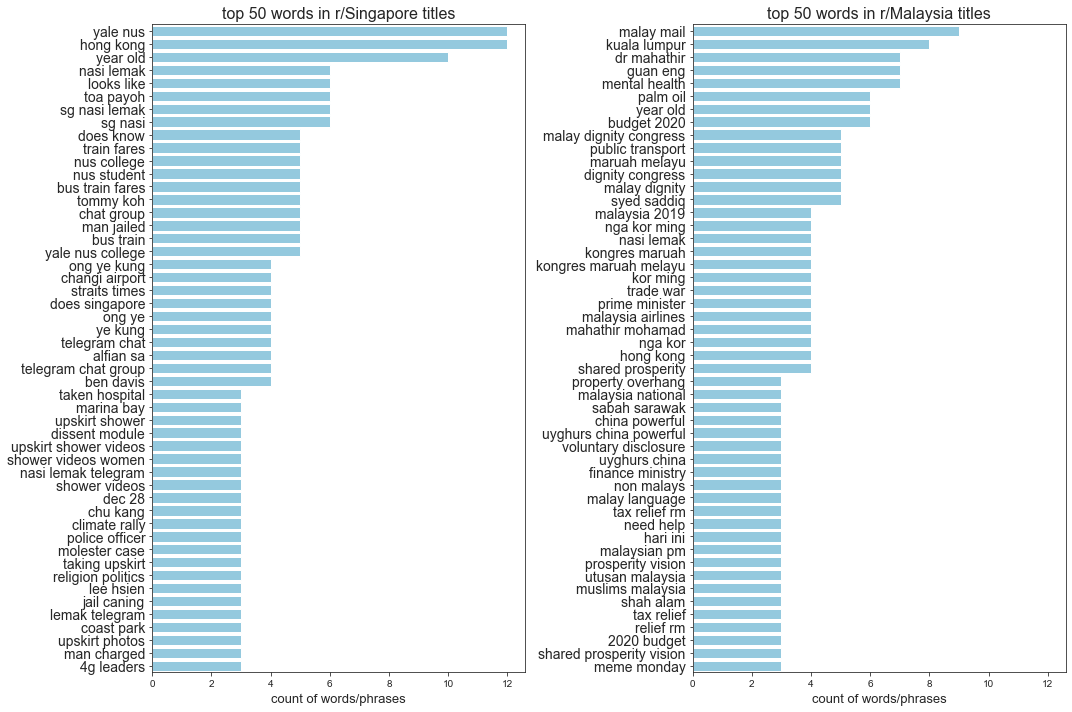

In [71]:
# r/Singapore - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_sg = cvec.fit_transform(sg_merged['title'])
vec_sg = pd.DataFrame(vec_sg.toarray(), columns = cvec.get_feature_names())
sg_title_50 = vec_sg.sum().sort_values(ascending=False).head(50)

# r/Malaysia - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_ms = cvec.fit_transform(ms_merged['title'])
vec_ms = pd.DataFrame(vec_ms.toarray(), columns = cvec.get_feature_names())
ms_title_50 = vec_ms.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=sg_title_50.index.values, x = sg_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/Singapore titles',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=ms_title_50.index.values, x = ms_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/Malaysia titles',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

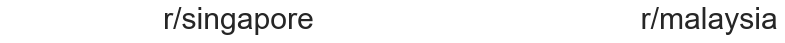

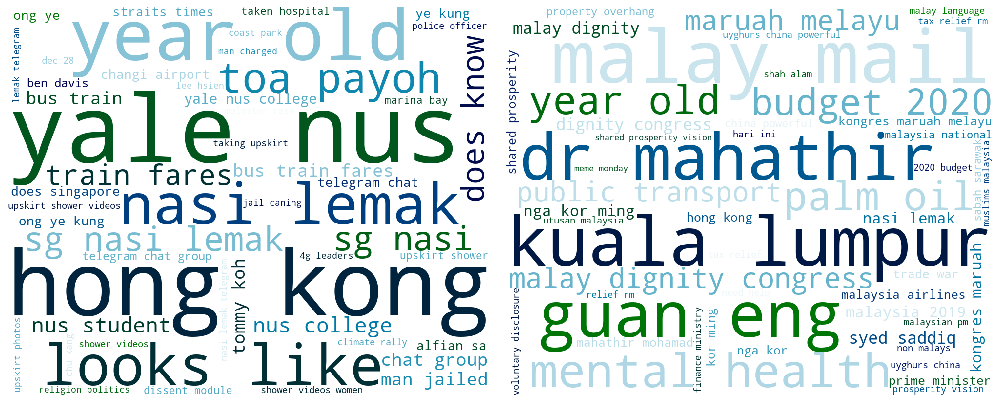

In [72]:
# set up WordCloud
wc_sg = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(sg_title_50) 

wc_ms = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(ms_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/singapore                                       r/malaysia', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_sg)
ax[0].axis('off')
ax[1].imshow(wc_ms)
ax[1].axis('off')
plt.tight_layout()

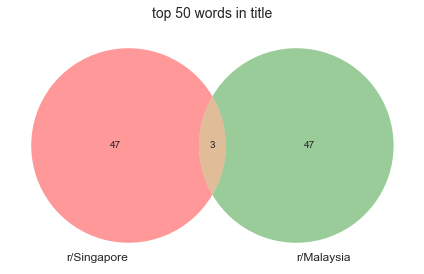

In [73]:
venn2([set(sg_title_50.index), set(ms_title_50.index)], set_labels = ('r/Singapore','r/Malaysia'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

### Post content

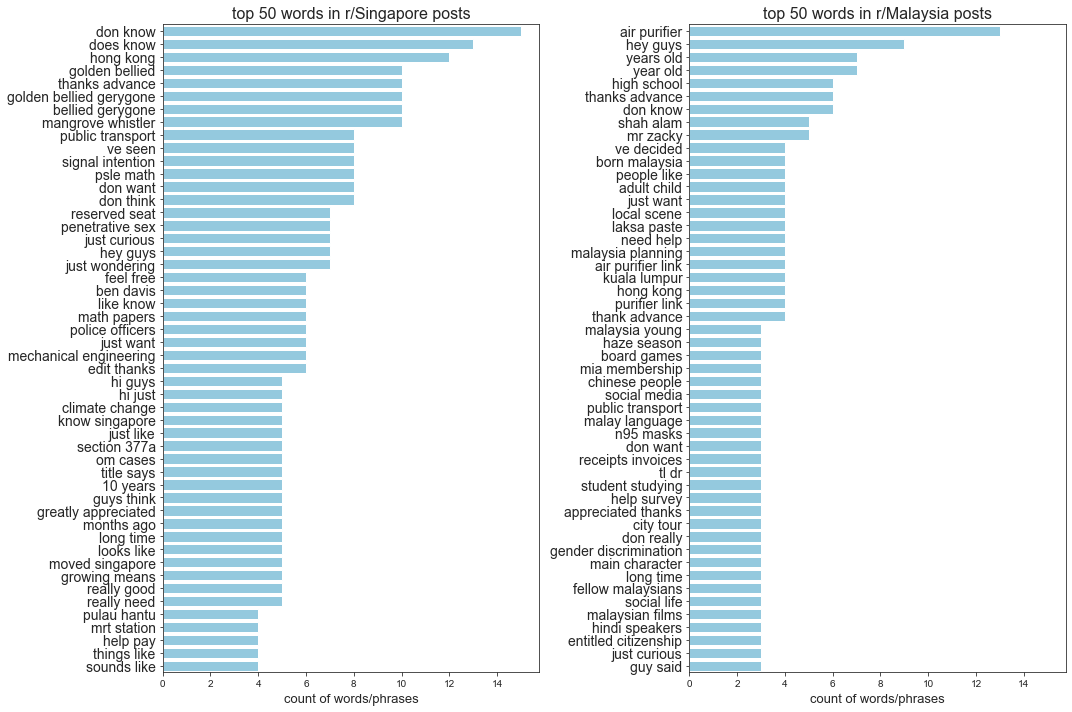

In [74]:
# r/Singapore - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_sg = cvec.fit_transform(sg_merged['text'])
vec_sg = pd.DataFrame(vec_sg.toarray(), columns = cvec.get_feature_names())
sg_post_50 = vec_sg.sum().sort_values(ascending=False).head(50)

# r/Malaysia - fit/transform count vectoriser to title and get the 50 phrases with the highest count
vec_ms = cvec.fit_transform(ms_merged['text'])
vec_ms = pd.DataFrame(vec_ms.toarray(), columns = cvec.get_feature_names())
ms_post_50 = vec_ms.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=sg_post_50.index.values, x = sg_post_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in r/Singapore posts',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=ms_post_50.index.values, x = ms_post_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in r/Malaysia posts',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

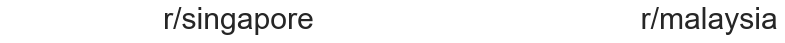

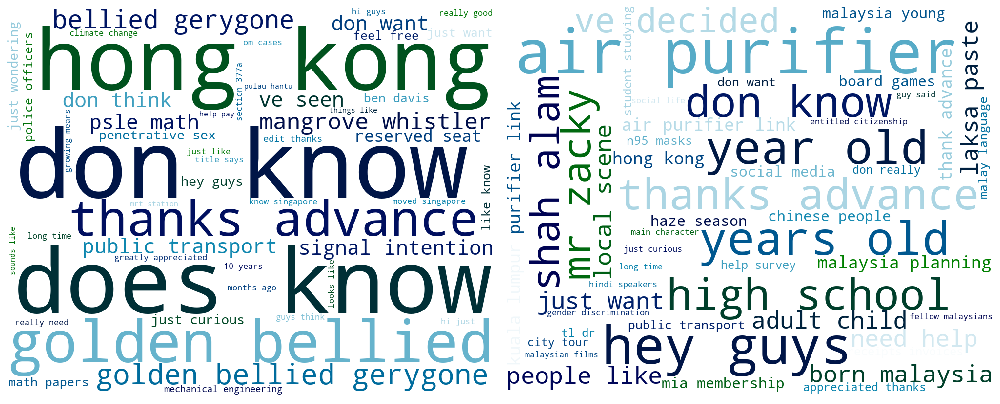

In [75]:
# set up WordCloud
wc_sg = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(sg_post_50) 

wc_ms = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='white',
                  colormap='ocean').generate_from_frequencies(ms_post_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'r/singapore                                       r/malaysia', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_sg)
ax[0].axis('off')
ax[1].imshow(wc_ms)
ax[1].axis('off')
plt.tight_layout()

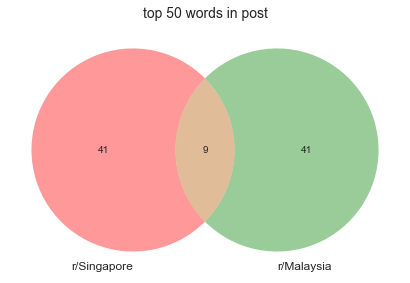

In [76]:
venn2([set(sg_post_50.index), set(ms_post_50.index)], set_labels = ('r/Singapore','r/Malaysia'))
plt.title('top 50 words in post', fontsize=14)
plt.tight_layout()

## EDA conclusion
---

From EDA, it was apparent that the raw data contained a large amount of noise, most of which I was able to remove with data cleaning. Titles seemed more informative than posts, likely due at least in part to the low percentage of posts that contain actual text, and will therefore likely be a better predictor for subreddit class. In the next notebook, I will examine how each feature contribute to the final model results, and how well the model is able to distinguish between the two subreddits.

### Export combined CSV (training data)

In [77]:
combined.to_csv('../data/combined_train.csv')

### Preprocess and export combined CSV (test data)

In [78]:
# read in test CSVs
sg_posts_test = pd.read_csv('../data/test/sg_posts_test.csv', index_col = 0)
sg_comments_test = pd.read_csv('../data/test/sg_comments_test.csv', index_col = 0)
ms_posts_test = pd.read_csv('../data/test/ms_posts_test.csv', index_col = 0)
ms_comments_test = pd.read_csv('../data/test/ms_comments_test.csv', index_col = 0)

# run preprocessing function
sg_merged_test = preprocess(sg_posts_test, sg_comments_test)
ms_merged_test = preprocess(ms_posts_test, ms_comments_test)

# create dummy column for subreddits - 1 for r/singapore and 0 for r/malaysia
sg_merged_test['subreddit'] = 1
ms_merged_test['subreddit'] = 0

# combine dataframes
combined_test = sg_merged_test.append(ms_merged_test)

# remove posts earlier than 18 oct 2019 (to prevent overlap with training data)
combined_test['date_created'] = pd.to_datetime(combined_test['date_created'])
combined_test = combined_test[combined_test['date_created'] > '2019-10-18']

# check how many rows remain
print(combined_test.shape)

# save to csv
combined_test.to_csv('../data/combined_test.csv')

(328, 12)
